## Projet tutoré sur les bénéficiaires effectifs : Analyse des données

#### Importer les librairies

In [49]:
import pandas as pd
import psycopg2

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

#### Se connecter à la base de données récupérer les données JSON

In [19]:
 # Paramètres de connexion à la base de données
dbname = "interlend220228"
user = "postgres"
password = "postgres"
host = "localhost"

# Initialiser une liste vide pour stocker les données extraites
data_list = []

try:
    # Connexion à la base de données
    conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host)
    cur = conn.cursor()

    # Sélectionner toutes les entrées de la table
    cur.execute("SELECT siren, result FROM rne.siren_info")

    # Pour chaque entrée dans la base de données
    for row in cur.fetchall():
        siren = row[0]  # Le numéro SIREN
        data = row[1]  # Le champ JSON

        # Exemple d'extraction
        if "formality" in data and "content" in data["formality"] and "personneMorale" in data["formality"]["content"]:
            forme_juridique = data["formality"]["content"]["natureCreation"].get("formeJuridique", "")
            societe_etrangere = data["formality"]["content"]["natureCreation"].get("societeEtrangere", "")
            adresse = data["formality"]["content"]["personneMorale"].get("adresseEntreprise", {}).get("adresse", {})
            commune = adresse.get("commune", "")
            code_postal = adresse.get("codePostal", "")
            data_list.append({"siren": siren, "forme_juridique": forme_juridique, "societe_etrangere": societe_etrangere, "commune": commune, "code_postal": code_postal})
except Exception as e:
    print(f"Erreur : {e}")
finally:
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

####

#### Créer un dataframe et l'afficher pour vérifier

In [71]:
# Créer un DataFrame à partir de la liste de données
df = pd.DataFrame(data_list)

In [132]:
df2 = df.copy()

In [133]:
df2.shape

(353403, 5)

In [136]:
df2.head(10)

,siren,forme_juridique,societe_etrangere,commune,code_postal
0,413510090,[5599],[False],[SAVIGNEUX],[01480]
1,813180163,[6540],[False],[CHANTELLE],[03140]
2,848098075,[6540],[False],[MEILLONNAS],[01370]
3,529253676,[6540],[False],[CERNEX],[74350]
4,398385393,[6540],[False],[MEILLONNAS],[01370]
5,533037362,[6540],[False],[BRESSE VALLONS],[01340]
6,481020022,[5710],[False],[VILLENEUVE D'ASCQ],[59650]
7,327095840,[5710],[False],[VIRIEU-LE-GRAND],[01510]
8,453022493,[6540],[False],[JUVIGNY],[02880]
9,749980330,[6540],[False],[NOYON],[60400]


#### Résoudre le problème de certaines données contenues dans les listes

In [137]:
def clean_data(cell):
    if isinstance(cell, list):
        return cell[0]
    else:
        return cell
df2 = df2.applymap(clean_data)


/var/folders/32/t8k4f_4d55nds458_sr5k_d80000gn/T/ipykernel_50293/4044957841.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(clean_data)


In [139]:
df2.head()

,siren,forme_juridique,societe_etrangere,commune,code_postal
0,413510090,5599,False,SAVIGNEUX,01480
1,813180163,6540,False,CHANTELLE,03140
2,848098075,6540,False,MEILLONNAS,01370
3,529253676,6540,False,CERNEX,74350
4,398385393,6540,False,MEILLONNAS,01370


In [142]:
# df2.to_csv("data/inpi_rbe_metadata.csv")

### Quelques analyses

#### Les 20 communes avec le plus grand nombre d’entreprises

<Axes: xlabel='commune'>

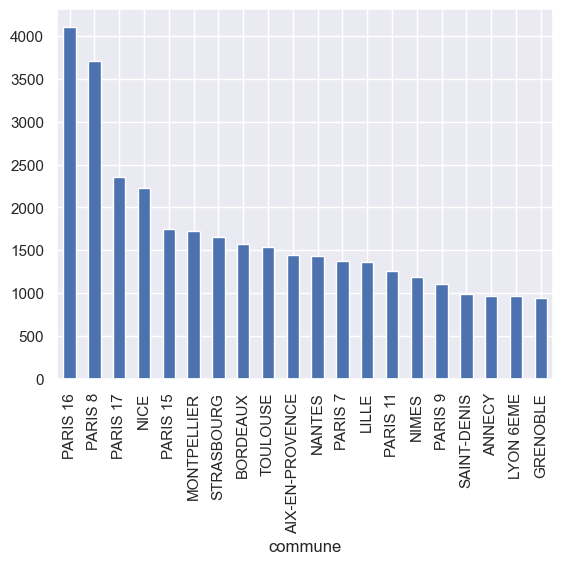

In [141]:
df2["commune"].value_counts()[:20].plot(kind="bar")

### Les formes juridiques des entreprises

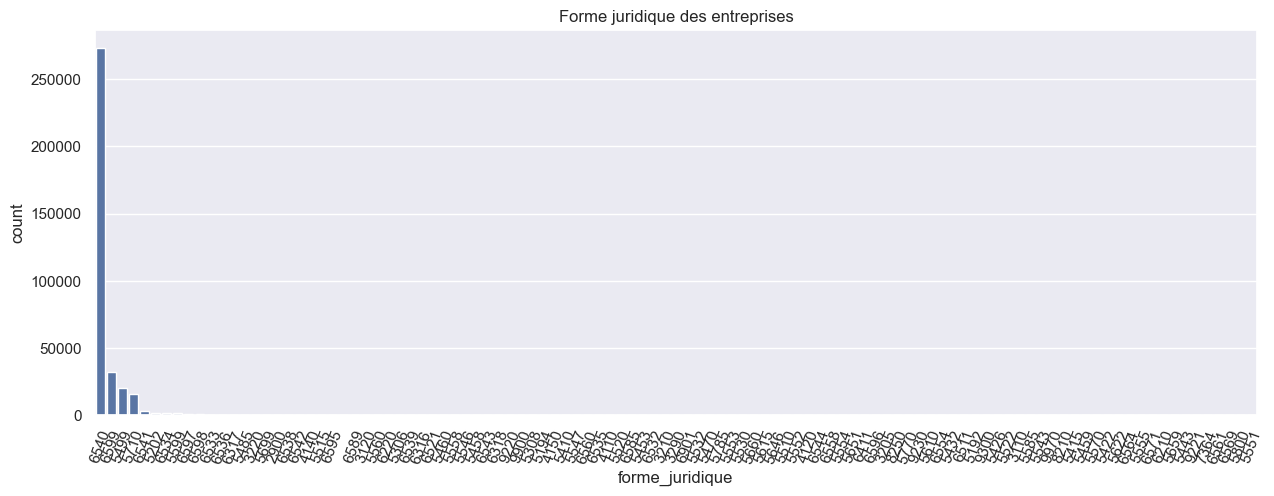

In [143]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=df2, x=df2["forme_juridique"], order=df2["forme_juridique"].value_counts().index)
plt.xticks(rotation = 70)
plt.title("Forme juridique des entreprises")
plt.show()